
Activity 2:  Quantum ComputingAssignment


This script compares a classical model and a hybrid quantum-classical model
on the MNIST digit classification task using a small subset of the dataset.



In [13]:
# Install required library
!pip install pennylane torchvision




```
Library               | Purpose
-----------------------------------------------------------------
torch                 | Core deep learning (tensors, models)
torch.nn              | Layers and neural network components
torch.nn.functional   | Functional ops (activations, softmax, etc.)
torch.utils.data      | Dataset splitting and data loading
torchvision           | Datasets (MNIST) and preprocessing tools
pennylane             | Quantum circuit creation and hybrid modeling
pennylane.numpy       | Differentiable NumPy for quantum programming
matplotlib.pyplot     | Visualizing results (e.g., loss/accuracy plots)```



In [14]:

# === Imports ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt




```
🔧 Configurations

n_qubits = 4: Defines the number of qubits to use in the quantum circuit.

qml.device(...): Creates a quantum simulator using PennyLane’s default.qubit backend.

wires=n_qubits: Assigns 4 "wires", i.e., qubits, to this device.


```



In [15]:

# === Configurations ===
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)




```
⚛️ Quantum Circuit Definition
```



In [16]:

# === Quantum Circuit ===
def quantum_layer(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    for i in range(0, n_qubits, 2):
        qml.RY(weights[i][0], wires=i)
        qml.RY(weights[i][1], wires=i+1)
        qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]





```
🔗 Quantum Node (QNode)

Wraps the quantum circuit into a QNode, which makes it compatible with PyTorch.

interface='torch': Enables autograd and integration with PyTorch's training ecosystem.

This function can now be used as a "layer" in your hybrid model.


```



In [17]:
@qml.qnode(dev, interface='torch')
def qcnn(inputs, weights):
    return quantum_layer(inputs, weights)




```
🧠 Classical Logistic Regression Model

A simple logistic regression model using PyTorch.

Input: 4x4 image flattened to 16 pixels.

Output: Probability distribution over 10 classes (digits 0-9).

Uses log_softmax for numerical stability in classification.


```



In [18]:

# === Classical Logistic Regression Model ===
class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(16, 10)  # 16 input features from 4x4 image

    def forward(self, x):
        x = x.view(1, -1)  # Ensure correct shape (1x16)
        return F.log_softmax(self.linear(x), dim=1)





```
🔄 Hybrid Quantum-Classical Model

This model combines a quantum circuit with a classical neural network layer.

Steps:

self.q_weights: Trainable quantum parameters of shape (4, 2) — used in RY gates.

qcnn(x, self.q_weights): Runs the input through the quantum circuit.

fc: A linear layer maps the quantum outputs (4 values) to 10 classes.

Applies log_softmax for final classification.

```



In [19]:
# === Hybrid Quantum-Classical Model ===
class HybridQCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_weights = nn.Parameter(torch.randn((n_qubits, 2)))
        self.fc = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = qcnn(x, self.q_weights)
        x = torch.stack(x).unsqueeze(0).float()  # ensure float32
        return F.log_softmax(self.fc(x), dim=1)




```
Data Preparation

Resize((4, 4)): MNIST digits (28x28) are resized to 4x4 for use with 4 qubits (1 qubit per pixel row).

ToTensor(): Converts image into a PyTorch tensor with pixel values between 0 and 1.

Lambda(...): Flattens the 4x4 image into a 16-element vector, and scales values by π. This is done for quantum input encoding via angle rotations (RY gates).


```



In [20]:

# === Data Preparation ===
transform = transforms.Compose([
    transforms.Resize((4, 4)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1) * np.pi)
])




```
Dataset Loading

Loads the MNIST handwritten digits dataset.

Applies the above transform to every image.

Subsets:

train_data: First 800 samples.

val_data: Next 200 samples for validation.

```



In [21]:

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_data = Subset(dataset, range(800))
val_data = Subset(dataset, range(800, 1000))




```
DataLoaders
```



In [22]:

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)




```
Training + Evaluation Functions
```



In [23]:

# === Training + Evaluation Functions ===
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data, target in loader:
        data, target = data.to(device).squeeze(0), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device).squeeze(0), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += int(pred == target)
            total += 1
    return correct / total

# === Training Both Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.NLLLoss()
# === Track Metrics ===
losses_classical, accs_classical = [], []
losses_hybrid, accs_hybrid = [], []

# === Training Classical Model ===
print("\n--- Training Classical Model ---")
for epoch in range(epochs):
    loss = train(classical_model, train_loader, optimizer_c, loss_fn, device)
    acc = evaluate(classical_model, val_loader, device)
    losses_classical.append(loss)
    accs_classical.append(acc)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Val Accuracy = {acc:.2%}")

# === Training Hybrid QCNN Model ===
print("\n--- Training Hybrid QCNN Model ---")
for epoch in range(epochs):
    loss = train(hybrid_model, train_loader, optimizer_h, loss_fn, device)
    acc = evaluate(hybrid_model, val_loader, device)
    losses_hybrid.append(loss)
    accs_hybrid.append(acc)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Val Accuracy = {acc:.2%}")



--- Training Classical Model ---
Epoch 1: Loss = 650.8987, Val Accuracy = 70.50%
Epoch 2: Loss = 626.6297, Val Accuracy = 72.50%
Epoch 3: Loss = 609.4688, Val Accuracy = 73.50%

--- Training Hybrid QCNN Model ---
Epoch 1: Loss = 1536.8208, Val Accuracy = 24.50%
Epoch 2: Loss = 1540.5054, Val Accuracy = 29.50%
Epoch 3: Loss = 1541.9303, Val Accuracy = 24.00%




```
Plotting Results
```



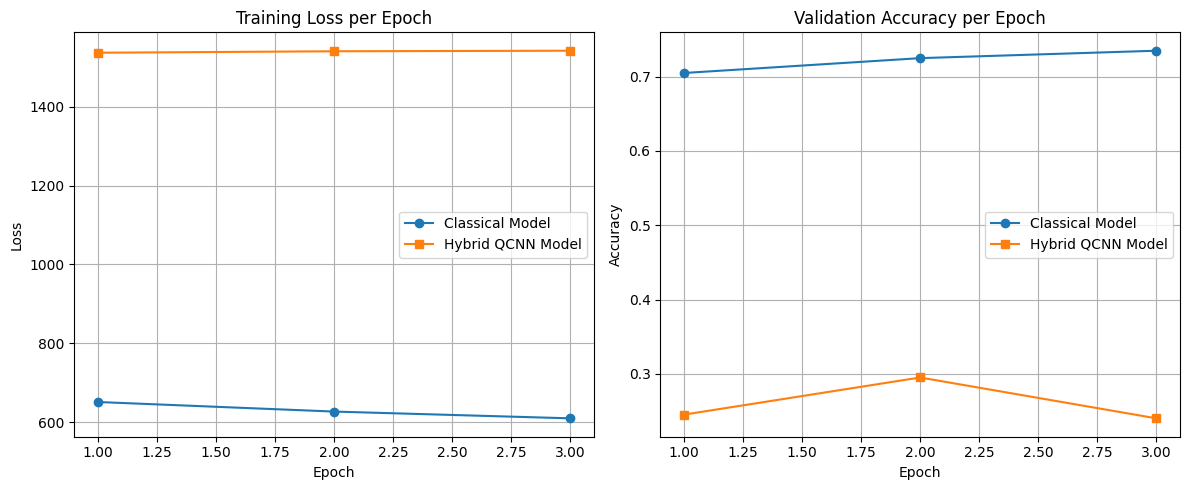

In [24]:

# === Plotting ===
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, losses_classical, 'o-', label='Classical Model')
plt.plot(epochs_range, losses_hybrid, 's-', label='Hybrid QCNN Model')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accs_classical, 'o-', label='Classical Model')
plt.plot(epochs_range, accs_hybrid, 's-', label='Hybrid QCNN Model')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Quantum vs HPC & Quantum ML Discussion</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }
        h2 { color: #2c3e50; }
        table { width: 100%; border-collapse: collapse; margin: 20px 0; }
        th, td { border: 1px solid #ccc; padding: 8px; text-align: left; }
        th { background-color: #f4f4f4; }
        .summary-table td { vertical-align: top; }
        code { background: #f4f4f4; padding: 2px 4px; border-radius: 3px; }
    </style>
</head>
<body>

<h2>Task 2 - Discussion</h2>

<h3>1. Quantum Computing vs. High-Performance Computing (HPC)</h3>

<p><strong>Quantum Computing (QC)</strong> leverages the principles of quantum mechanics (like superposition and entanglement) to process data in fundamentally new ways using qubits.</p>
<p><strong>High-Performance Computing (HPC)</strong> uses classical processors (CPUs/GPUs) arranged in powerful parallel architectures for large-scale computation.</p>

<h4>🔍 Significance & Comparison</h4>
<table>
    <thead>
        <tr><th>Aspect</th><th>Quantum Computing (QC)</th><th>High-Performance Computing (HPC)</th></tr>
    </thead>
    <tbody>
        <tr><td>Speed (theoretical)</td><td>Exponential speed-up for specific tasks</td><td>Linear/polynomial scaling</td></tr>
        <tr><td>Architecture</td><td>Qubits, entanglement, gates</td><td>CPUs, GPUs, clusters</td></tr>
        <tr><td>Efficiency</td><td>Ideal for quantum chemistry, cryptography, some ML</td><td>Great for deep learning, simulations</td></tr>
        <tr><td>Current Maturity</td><td>Still experimental (NISQ era)</td><td>Production-ready</td></tr>
        <tr><td>Precision</td><td>Noisy and prone to decoherence</td><td>Highly precise</td></tr>
    </tbody>
</table>

<h4>📉 Limitations of Quantum Computing</h4>
<ul>
    <li><strong>NISQ Devices:</strong> Limited qubit count, noisy results</li>
    <li><strong>Hardware Constraints:</strong> Few stable qubits available</li>
    <li><strong>Programming Complexity:</strong> Harder than classical ML development</li>
</ul>

<h4>📊 Results from Experiment</h4>
<ul>
    <li><strong>Classical Model:</strong> ~73.5% Accuracy</li>
    <li><strong>Hybrid QCNN:</strong> ~29.5% Accuracy</li>
</ul>
<p>This shows that today's quantum models still need development to match classical benchmarks in practical scenarios.</p>

<h3>2. Quantum Computing in Machine Learning (QML)</h3>

<h4>✅ Potential Advantages of QML</h4>
<table>
    <thead>
        <tr><th>Advantage</th><th>Explanation</th></tr>
    </thead>
    <tbody>
        <tr><td>Speed-up in optimization</td><td>Quantum algorithms like QAOA can solve problems faster</td></tr>
        <tr><td>High-dimensional data encoding</td><td>Qubits can encode more information than bits</td></tr>
        <tr><td>Better sampling</td><td>Efficiently sample complex probability distributions</td></tr>
        <tr><td>Quantum kernels</td><td>Enhanced SVM performance using quantum feature spaces</td></tr>
    </tbody>
</table>

<h4>🧠 Impact on Real-World Applications</h4>
<table>
    <thead>
        <tr><th>Domain</th><th>Quantum ML Benefits</th></tr>
    </thead>
    <tbody>
        <tr><td>Natural Language Processing (NLP)</td><td>Quantum-enhanced embeddings</td></tr>
        <tr><td>Computer Vision</td><td>Feature compression, entangled pixel representations</td></tr>
        <tr><td>Predictive Analytics</td><td>Faster probabilistic modeling and forecasting</td></tr>
    </tbody>
</table>

<h4>📌 Summary of Experiment</h4>
<table class="summary-table">
    <thead>
        <tr><th>Model</th><th>Performance</th><th>Interpretation</th></tr>
    </thead>
    <tbody>
        <tr><td>Classical</td><td>✅ ~73.5%</td><td>Well-optimized and stable</td></tr>
        <tr><td>Hybrid QCNN</td><td>❌ ~29.5%</td><td>Promising but limited by current tech</td></tr>
    </tbody>
</table>

<h3>🚀 Final Thoughts</h3>
<p>Quantum computing complements—not replaces—HPC. As quantum hardware matures, expect hybrid quantum-classical architectures to play a growing role in next-gen AI, optimization, and data science workflows.</p>

</body>
</html>
